In [5]:
import torch.nn as nn
import torch 

In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, 
                 context_length, dropout,
                 num_heads, qkv_bias=False):
        super().__init__()
        assert(d_out % num_heads == 0), "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # 1

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        self.out_proj = nn.Linear(d_out, d_out) # 2

        self.dropout = nn.Dropout(dropout) 
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1),
        ) 

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # 3
        queries = self.W_query(x) # 3
        values = self.W_value(x) # 3

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) # 4
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1, 2) # 5
        queries = queries.transpose(1, 2) # 5
        values = values.transpose(1, 2) # 5

        attn_scores = queries @ keys.transpose(2, 3) # omega # 6
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens] # 7

        attn_scores.masked_fill_(mask_bool, -torch.inf) # 8

        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2) # 9
        context_vec = context_vec.contiguous().view( # 10
            b, num_tokens, self.d_out
        )

        context_vec = self.out_proj(context_vec) # 11
        return context_vec

In [7]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        # layers to train the model
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
        )
    
    def forward(self, x):
        return self.layers(x)


class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    
    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True)
        var = x.var(dim = -1, keepdim = True)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return 0.5 * x * (
            1 + torch.tanh(
                torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
                (x + 0.044715 * torch.pow(x, 3))
            )
        )

In [8]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        
        # multi-head attention
        self.att = MultiHeadAttention(
            # input dim
            d_in = cfg["emb_dim"],
            # output dim
            d_out = cfg["emb_dim"],
            # actual input length
            context_length = cfg["context_length"],
            # number of causal attention 
            num_heads = cfg["n_heads"],
            # masking rate
            dropout = cfg["drop_rate"],
            # if adding query, key, and value bias
            qkv_bias = cfg["qkv_bias"]
        )

        # Apply layers and activation function to train the model
        self.ff = FeedForward(cfg)

        # normalization
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        
        # masking
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    
    def forward(self, x):
        # 1

        # assgin input as shortcut
        shortcut = x

        # normalize input
        x = self.norm1(x)

        # get context vector
        x = self.att(x)

        # dropout
        x = self.drop_shortcut(x)

        # shortcut: add input to output 
        x = x + shortcut # 2

        # assgin transformed input to shortcut 
        shortcut = x # 3

        # normalizing
        x = self.norm2(x)

        # apply linear layers and activation functions to input
        x = self.ff(x)

        # drop
        x = self.drop_shortcut(x)

        # shortcut: add input to output 
        x = x + shortcut # 4

        return x

In [9]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # create token embeddings
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"], cfg["emb_dim"])

        # create positional embeddings
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])

        # set drop out rate
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Apply transfomer block with n_layers
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        # Apply layer normalization to embedding layers
        self.final_norm = LayerNorm(cfg["emb_dim"])

        # create output layers
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias = False
        )
    
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape

        # create token embeddings
        tok_embeds = self.tok_emb(in_idx)

        # create positional embeddings
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device = in_idx.device) # 1
        )
        
        # combine token and positional embeddings
        x = tok_embeds + pos_embeds

        # drop some layers
        x = self.drop_emb(x)

        # apply transformer blocksbb
        x = self.trf_blocks(x)

        # normalizing
        x = self.final_norm(x)

        # apply linear function to x and return probbaility of each token and text
        logits = self.out_head(x)
        
        return logits

## Using GPT to generate text

In [10]:
#1 We shorten the context length from 1,024 to 256 tokens.
#2 It’s possible and common to set dropout to 0.

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,    #1
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12, 
    "drop_rate": 0.1,       #2
    "qkv_bias": False
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768, padding_idx=768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): L

In [11]:
def generate_text_simple(model, idx,  # 1
                         max_new_tokens, context_size):
    
    # iterate number of max new tokens provided
    for _ in range(max_new_tokens):

        # extract last number of context size
        idx_cond = idx[:, -context_size:] # 2

        # Disables gradient tracking since we are not training yet
        with torch.no_grad():
            # Obtain logits
            logits = model(idx_cond)

        # only extract the last row from a tensor
        logits = logits[:, -1, :] # 3

        # Obtain probability through softmax
        # Probability of each token in vocabulary
        probas = torch.softmax(logits, dim = -1) # 4
        
        # find the max probability
        idx_next = torch.argmax(probas, dim = -1, keepdim = True) # 5
        
        # find the index corresponding to the max proba
        idx = torch.cat((idx, idx_next), dim = 1) # 6

    return idx

In [12]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special = {'<|endoftext|>'})
    # 1
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    # 2
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

embeddings = text_to_token_ids(start_context, tokenizer)

token_ids = generate_text_simple(
    model = model,
    idx = embeddings,
    max_new_tokens = 10,
    context_size = GPT_CONFIG_124M["context_length"]
)

print("Output text: \n", token_ids_to_text(token_ids, tokenizer))


Output text: 
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


## 5.1.2 Calculating the text generation loss

In [13]:
#  targets are the inputs but shifted one position forward

inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107, 588, 11311]])  #  " really like chocolate"]

In [14]:
#1 Disables gradient tracking since we are not training yet
#2 Probability of each token in vocabulary

with torch.no_grad():     #1
    logits = model(inputs)
    
probas = torch.softmax(logits, dim=-1)     #2
print(probas.shape)


torch.Size([2, 3, 50257])


In [15]:
#1 First batch
#2 Second batch

token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [16]:
# The model produces random text 
# that is different from the target text because it has not been trained yet. 

print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:"
      f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [17]:
probas

tensor([[[1.8852e-05, 1.5172e-05, 1.1698e-05,  ..., 2.2408e-05,
          6.9822e-06, 1.8781e-05],
         [9.1619e-06, 1.0067e-05, 7.8848e-06,  ..., 2.9088e-05,
          6.0139e-06, 1.3577e-05],
         [2.9887e-05, 8.8599e-06, 1.5754e-05,  ..., 3.5435e-05,
          1.4104e-05, 1.3535e-05]],

        [[1.2571e-05, 2.0535e-05, 1.4342e-05,  ..., 1.0396e-05,
          3.4776e-05, 1.4245e-05],
         [7.2785e-06, 1.7863e-05, 1.0568e-05,  ..., 2.1211e-05,
          1.1390e-05, 1.5565e-05],
         [2.9499e-05, 3.3594e-05, 4.1009e-05,  ..., 6.5304e-06,
          5.8152e-05, 1.3705e-05]]])

In [18]:
# batch: 0
# [0, 1, 2]: extract the first three rows
# targets[0] = [a, b, c] where a, b, c are three indices corresponding to three words

text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4514e-05, 3.1054e-05, 1.1567e-05])
Text 2: tensor([1.0343e-05, 5.6737e-05, 4.7620e-06])


## Backpropagation

In [19]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5045, -10.3798, -11.3674, -11.4792,  -9.7771, -12.2549])


In [20]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7938)


In [21]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7938)


## Cross_entropy

In [22]:
print("Logits shape: ", logits.shape)
print("Targets shape: ", targets.shape)

Logits shape:  torch.Size([2, 3, 50257])
Targets shape:  torch.Size([2, 3])


In [23]:
# combine batches

logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits: ", logits_flat.shape)
print("Flattened targets: ", targets_flat.shape)

Flattened logits:  torch.Size([6, 50257])
Flattened targets:  torch.Size([6])


In [24]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7938)


## Perplexity

In [25]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48717.6914)


## Calculating the training and validation set losses

In [26]:
# load data
file_path = "the-verdict.txt"
with open(file_path, "r", encoding = 'utf-8') as file:
    text_data = file.read()

In [27]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters: ", total_characters)
print("Tokens: ", total_tokens)

Characters:  20479
Tokens:  5145


In [28]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [29]:
import torch
from torch.utils.data import Dataset, DataLoader

class GPTDatasetv1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt) #1
        
        # The stride setting dictates the number of positions the inputs shift across batches, 
        #   emulating a sliding window approach
        for i in range(0, len(token_ids) - max_length, stride): #2
            input_chunk = token_ids[i:i + max_length]
            target_chunck = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunck))
    
    def __len__(self):  #3
        return len(self.input_ids)
    
    def __getitem__(self, idx):     #4
        return self.input_ids[idx], self.target_ids[idx]

In [30]:
def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")                         #1
    dataset = GPTDatasetv1(txt, tokenizer, max_length, stride)   #2
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,     #3
        num_workers=num_workers     #4
    )

    return dataloader

In [31]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size = 2,
    max_length = GPT_CONFIG_124M["context_length"],
    stride = GPT_CONFIG_124M["context_length"],
    drop_last = True,
    num_workers = 0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size = 2,
    max_length = GPT_CONFIG_124M["context_length"],
    stride = GPT_CONFIG_124M["context_length"],
    drop_last = False,
    shuffle = False,
    num_workers = 0
)

In [32]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [33]:
#1 The transfer to a gievn device allows us to transfer the data to a GPU
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)         #1
    target_batch = target_batch.to(device)      
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss

In [34]:
#1 Iteratives over all batches if no fixed num_batches is specified
#2 Reduces the number of batches to match the total number of batches in the data loader if num_batches exceeds the number of batches in the data loader
#3 Sums loss for each batch
#4 Averages the loss over all batches

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)     #1
    else:
        num_batches = min(num_batches, len(data_loader))   #2
        
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()    #3
        else:
            break
    return total_loss / num_batches    #4

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device=device)
    val_loss = calc_loss_loader(val_loader, model, device=device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

c:\Users\42128\miniconda3\lib\site-packages\torch\cuda\__init__.py:128: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 1: invalid argument (Triggered internally at C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Training loss: 10.987384902106392
Validation loss: 10.980905532836914


## Training a LLM

In [36]:
def evaluate_model(model, train_loader, val_loader, 
                   device, eval_iter):
    # 1 Dropout is disabled during evaluation for stable, reproducible results.
    model.eval()
    with torch.no_grad():
        # 2 Disables gradient tracking, which is not required during evaluation, 
        #   to reduce the computational overhead
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches = eval_iter
        )
        
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches = eval_iter
        )
    
    model.train()
    return train_loss, val_loss

In [37]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)

    with torch.no_grad():
        token_ids = generate_text_simple(model = model, idx = encoded, 
                                         max_new_tokens = 50, context_size = context_size)
        
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    
    # 1 Compact print format
    print(decoded_text.replace("\n", " "))
    model.train()

In [43]:
def train_model_simple(model, train_loader, val_loader, 
                       optimizer, device, num_epochs, 
                       eval_freq, eval_iter, start_context, 
                       tokenizer):
    # 1 Initializes lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # 2 Starts the main training loop
    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            # 3 Resets loss gradients from the previous batch iteration
            optimizer.zero_grad()

            # calculate loss value over each batch
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )

            # 4 Calculates loss gradients
            loss.backward()

            # 5 Updates model weights using loss gradients
            optimizer.step()

            # numel(): returns the total number of elements in the input tensor
            tokens_seen += input_batch.numel()

            global_step += 1

            # 6 Optional evaluation step
            if global_step % eval_freq == 0:

                # evaluate model by trainning loss and validation loss
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                
                print(f"Ep {epoch + 1} (Step {global_step: 06d}): "
                      f"Train loss {train_loss: .3f}",
                      f"Val loss {val_loss: .3f}")
                
        # 7 Prints a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
    
    return train_losses, val_losses, track_tokens_seen

In [44]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
    # 1 The .parameters() method returns all trainable weight parameters of the model
    model.parameters(),
    lr = 0.0004, weight_decay = 0.1
)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs = num_epochs, eval_freq = 5, eval_iter = 5, 
    start_context = "Every effort moves you", tokenizer = tokenizer
)

Ep 1 (Step  00000): Train loss  9.784 Val loss  9.928
Ep 1 (Step  00005): Train loss  7.986 Val loss  8.336
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step  00010): Train loss  6.754 Val loss  7.049
Ep 2 (Step  00015): Train loss  6.114 Val loss  6.573
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,,,,, and,,,, and,, and,,,,, and,,,,,,
Ep 3 (Step  00020): Train loss  5.525 Val loss  6.489
Ep 3 (Step  00025): Train loss  5.325 Val loss  6.389
Every effort moves you, and to the picture.                      "I, and the of the of the's the honour, and, and I had been, and I
Ep 4 (Step  00030): Train loss  4.766 Val loss  6.361
Ep 4 (Step  00035): Train loss  4.462 Val loss  6.255
Every effort moves you of the to the picture--as of the picture--as I had been " it was his " I was the     "I was his I had been the his pictures--and it the picture and I had been the picture of
Ep 5 (Step  00040): Train loss  3.835 Val loss  6.196
Every effort

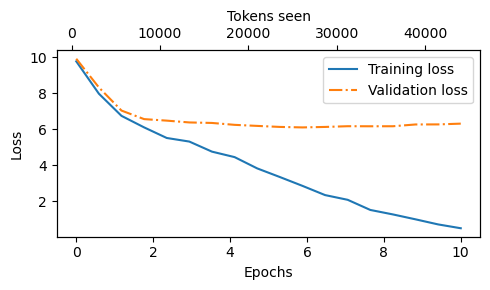

In [45]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
        epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    #1 Creates a second x-axis that shares the same y-axis
    ax2 = ax1.twiny()

    #2 Invisible plot for aligning ticks
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## Decoding strategies to control randomness